In [7]:
from pathlib import Path
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, ScalarFormatter
from pdb import set_trace

In [8]:
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
plt.rcParams["font.size"] = 16

In [9]:
def get_event_files(env, alg="ppo"):
    event_files = []
    directory_path = Path(f"./logs/{alg}/{env}_tensorboard")
    
    for d in directory_path.iterdir():
        if d.is_dir():
            event_files.append(str(next(d.iterdir())))
    
    return event_files

def get_rewards_from_event_files(event_files):
    rewards = []
    
    for file in event_files:
        event_acc = EventAccumulator(file)
        event_acc.Reload()

        # Get the reward data
        reward_data = event_acc.Scalars("rollout/ep_rew_mean")

        # Extract the step numbers and corresponding rewards
        _steps = [entry.step for entry in reward_data]
        _rewards = [entry.value for entry in reward_data]
        
        rewards.append(
            {
                "file": file,
                "steps": _steps,
                "rewards": _rewards,
                "steps_length": len(_steps),
                "rewards_length": len(_rewards),
            }
        )
    
    return rewards

In [10]:
def get_reward_stats(rewards, default_length=25):
    reward_list = []
    for r in rewards:
        if r["rewards_length"] == default_length:
            reward_list.append(np.array(r["rewards"])[np.newaxis, :])
        else:
            continue

    rewards_array = np.concatenate(reward_list, axis=0)

    reward_array = np.concatenate([np.array(r["rewards"])[np.newaxis, :] for r in rewards], axis=0)
    mean_reward = np.mean(reward_array, axis=0)
    min_reward = np.min(reward_array, axis=0)
    max_reward = np.max(reward_array, axis=0)
    
    return min_reward, mean_reward, max_reward

In [57]:
def plot_baseline(ax, env, alg="ppo", iters=5e4, default_length=25, ylower_lim=0.0):
    formatter = ScalarFormatter(useMathText=True)
    event_files = get_event_files(env, alg=alg)
    rewards = get_rewards_from_event_files(event_files)
    min_reward, mean_reward, max_reward = get_reward_stats(rewards, default_length=default_length)
    
    ax.plot(rewards[0]["steps"], mean_reward, color="cornflowerblue", linewidth=4)
    ax.fill_between(rewards[0]["steps"], min_reward, max_reward, color="cornflowerblue", alpha=0.3)
    ax.set_xlim([0, iters])
    ax.set_ylim([ylower_lim, 1.0])
    ax.ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
    ax.xaxis.major.formatter._useMathText = True

    ax.xaxis.set_major_locator(MultipleLocator(iters/4))
    ax.xaxis.set_minor_locator(MultipleLocator(iters/16))
    ax.yaxis.set_major_locator(MultipleLocator((1 - ylower_lim)/4))
    ax.yaxis.set_minor_locator(MultipleLocator((1 - ylower_lim)/16))

    ax.grid(True, "minor", color="0.85", linewidth=0.50, zorder=-20)
    ax.grid(True, "major", color="0.65", linewidth=0.75, zorder=-10)
    ax.tick_params(which="both", bottom=False, left=False)
    ax.set_title(env, pad=10)
    ax.set_xlabel("Time steps")

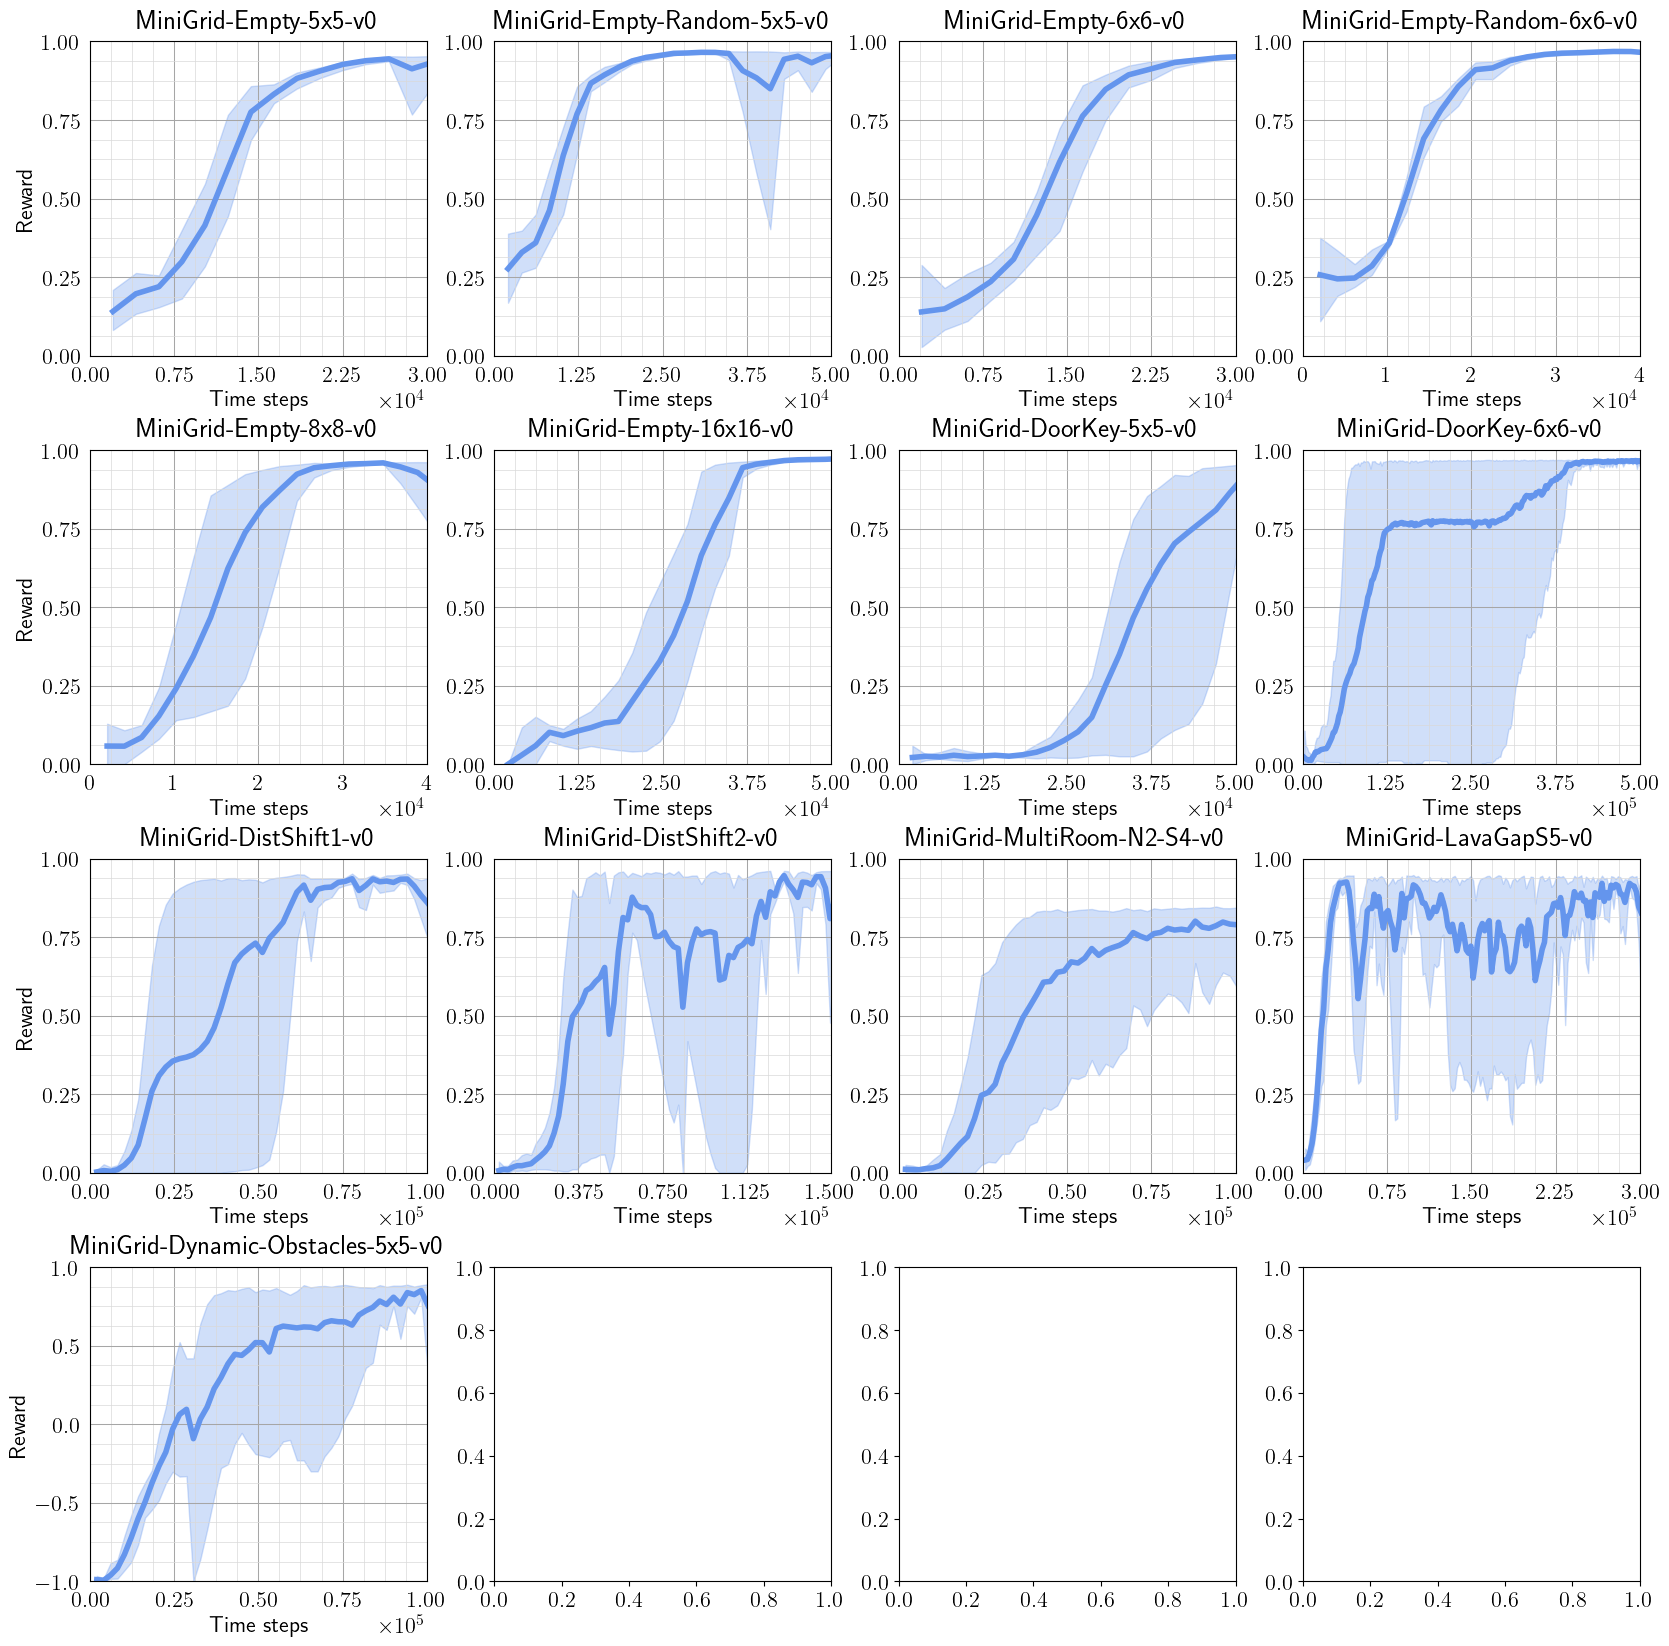

In [58]:
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
axs = axs.reshape(-1)

plot_baseline(axs[0], "MiniGrid-Empty-5x5-v0", alg="ppo", default_length=15, iters=3e4)
plot_baseline(axs[1], "MiniGrid-Empty-Random-5x5-v0", alg="ppo", default_length=25, iters=5e4)
plot_baseline(axs[2], "MiniGrid-Empty-6x6-v0", alg="ppo", default_length=15, iters=3e4)
plot_baseline(axs[3], "MiniGrid-Empty-Random-6x6-v0", alg="ppo", iters=4e4)
plot_baseline(axs[4], "MiniGrid-Empty-8x8-v0", alg="ppo", default_length=37, iters=4e4)
plot_baseline(axs[5], "MiniGrid-Empty-16x16-v0", alg="ppo")
plot_baseline(axs[6], "MiniGrid-DoorKey-5x5-v0", alg="ppo")
plot_baseline(axs[7], "MiniGrid-DoorKey-6x6-v0", alg="ppo", default_length=489, iters=5e5)
plot_baseline(axs[8], "MiniGrid-DistShift1-v0", alg="ppo", default_length=98, iters=1e5)
plot_baseline(axs[9], "MiniGrid-DistShift2-v0", alg="ppo", default_length=98, iters=1.5e5)
plot_baseline(axs[10], "MiniGrid-MultiRoom-N2-S4-v0", alg="ppo", default_length=49, iters=1e5)
plot_baseline(axs[11], "MiniGrid-LavaGapS5-v0", alg="ppo", default_length=147, iters=3e5)
plot_baseline(axs[12], "MiniGrid-Dynamic-Obstacles-5x5-v0", alg="ppo", default_length=49, iters=1e5, ylower_lim=-1)

axs[0].set_ylabel("Reward")
axs[4].set_ylabel("Reward")
axs[8].set_ylabel("Reward")
axs[12].set_ylabel("Reward")

plt.subplots_adjust(wspace=0.2, hspace=0.3)
plt.savefig("imgs/baseline.png", dpi=200, transparent=False, bbox_inches="tight")
plt.show()

In [52]:
event_files = get_event_files("MiniGrid-Dynamic-Obstacles-5x5-v0")
rewards = get_rewards_from_event_files(event_files)
rewards[2]['rewards_length']

49